<a href="https://colab.research.google.com/github/mainadwitiya/Daily_usage_codes/blob/main/fine_tune_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!nvidia-smi

Sun Apr 25 09:32:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    33W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
!unzip /content/gdrive/MyDrive/Final_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Final_dataset/validate/Grape___Esca_(Black_Measles)/image (616).JPG  
  inflating: Final_dataset/validate/Grape___Esca_(Black_Measles)/image (735).JPG  
  inflating: Final_dataset/validate/Grape___Esca_(Black_Measles)/image (107).JPG  
  inflating: Final_dataset/validate/Grape___Esca_(Black_Measles)/image (864).JPG  
  inflating: Final_dataset/validate/Grape___Esca_(Black_Measles)/image (642).JPG  
  inflating: Final_dataset/validate/Grape___Esca_(Black_Measles)/image (1237).JPG  
  inflating: Final_dataset/validate/Grape___Esca_(Black_Measles)/image (19).JPG  
  inflating: Final_dataset/validate/Grape___Esca_(Black_Measles)/image (175).JPG  
  inflating: Final_dataset/validate/Grape___Esca_(Black_Measles)/image (1331).JPG  
  inflating: Final_dataset/validate/Grape___Esca_(Black_Measles)/image (932).JPG  
  inflating: Final_dataset/validate/Grape___Esca_(Black_Measles)/image (802).JPG  
  inflating: Final_dataset/validate

In [6]:
import math, json, os, sys

import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing import image




In [7]:

DATA_DIR = 'Final_dataset'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VALID_DIR = os.path.join(DATA_DIR, 'validate')
SIZE = (256, 256)
BATCH_SIZE = 64


In [8]:
class Plant_disease():
    
   
    
    def dataset_gens(self):
        num_train_samples = sum([len(files) for r, d, files in os.walk(TRAIN_DIR)])
        num_valid_samples = sum([len(files) for r, d, files in os.walk(VALID_DIR)])

        num_train_steps = math.floor(num_train_samples/BATCH_SIZE)
        num_valid_steps = math.floor(num_valid_samples/BATCH_SIZE)

        gen = keras.preprocessing.image.ImageDataGenerator()
        val_gen = keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, vertical_flip=True)

        batches = gen.flow_from_directory(TRAIN_DIR, target_size=SIZE, class_mode='categorical', shuffle=True, batch_size=BATCH_SIZE)
        val_batches = val_gen.flow_from_directory(VALID_DIR, target_size=SIZE, class_mode='categorical', shuffle=True, batch_size=BATCH_SIZE)
        return batches,val_batches,num_train_steps,num_valid_steps
    
    def leaf_model(self):
        model = keras.applications.resnet50.ResNet50()
        classes = list(iter(batches.class_indices))
        model.layers.pop()
        for layer in model.layers:
            layer.trainable=False
        last = model.layers[-1].output
        x = Dense(len(classes), activation="softmax")(last)
        finetuned_model = Model(model.input, x)
        finetuned_model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
        for c in batches.class_indices:
            classes[batches.class_indices[c]] = c
        finetuned_model.classes = classes
        print(finetuned_model.summary())
        return finetuned_model,finetuned_model.classes
        
        



    def create_final_model(self,finetuned_model):
        early_stopping = EarlyStopping(patience=10)
        checkpointer = ModelCheckpoint('resnet50_best.h5', verbose=1, save_best_only=True)
        
        finetuned_model.fit_generator(batches, steps_per_epoch=num_train_steps, epochs=200, callbacks=[early_stopping, checkpointer], validation_data=val_batches, validation_steps=num_valid_steps)
        return finetuned_model

    

In [9]:
obj1=Plant_disease()
batches,val_batches,num_train_steps,num_valid_steps=obj1.dataset_gens()
finetuned_model,classes=obj1.leaf_model()



Found 30400 images belonging to 38 classes.
Found 5700 images belonging to 38 classes.
102973440/102967424 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 

In [10]:
obj1.create_final_model(finetuned_model)
finetuned_model.save('resnet50_final.h5')
        

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
475/475 [==============================] - 105s 180ms/step - loss: 3.5854 - accuracy: 0.2356 - val_loss: 3.4449 - val_accuracy: 0.5123

Epoch 00001: val_loss improved from inf to 3.44491, saving model to resnet50_best.h5
Epoch 2/200
475/475 [==============================] - 81s 171ms/step - loss: 3.3908 - accuracy: 0.5240 - val_loss: 3.2742 - val_accuracy: 0.5270

Epoch 00002: val_loss improved from 3.44491 to 3.27423, saving model to resnet50_best.h5
Epoch 3/200
475/475 [==============================] - 81s 170ms/step - loss: 3.2150 - accuracy: 0.5464 - val_loss: 3.1192 - val_accuracy: 0.5281

Epoch 00003: val_loss improved from 3.27423 to 3.11916, saving model to resnet50_best.h5
Epoch 4/200
475/475 [==============================] - 81s 170ms/step - loss: 3.0564 - accuracy: 0.5513 - val_loss: 2.9812 - val_accuracy: 0.5356

Epoch 00004: val_loss improved from 3.11916 to 2.98124, saving model to resnet50_best.h5
Epoch 5/200
475/475 [==============================] - 81s 

In [11]:
finetuned_model.history.history

{'accuracy': [0.3696381449699402,
  0.5260197520256042,
  0.5477631688117981,
  0.5494078993797302,
  0.5522368550300598,
  0.5549342036247253,
  0.5607565641403198,
  0.5669736862182617,
  0.5721052885055542,
  0.5785197615623474,
  0.5848684310913086,
  0.5904605388641357,
  0.5965131521224976,
  0.602335512638092,
  0.6092433929443359,
  0.6131250262260437,
  0.617927610874176,
  0.6236184239387512,
  0.6279276609420776,
  0.6315131783485413,
  0.6362500190734863,
  0.6416118144989014,
  0.644440770149231,
  0.6481907963752747,
  0.651546061038971,
  0.656348705291748,
  0.6595394611358643,
  0.6634868383407593,
  0.6660855412483215,
  0.6684210300445557,
  0.6723355054855347,
  0.6744078993797302,
  0.6759210228919983,
  0.67898029088974,
  0.6821052432060242,
  0.6839144825935364,
  0.6859868168830872,
  0.6881579160690308,
  0.690690815448761,
  0.6930263042449951,
  0.6958552598953247,
  0.6971710324287415,
  0.6997697353363037,
  0.7022039294242859,
  0.7040131688117981,
  0.70

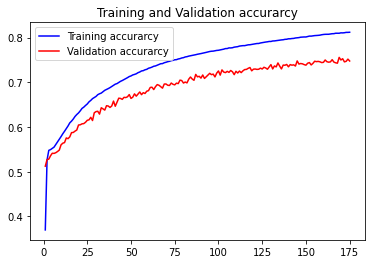

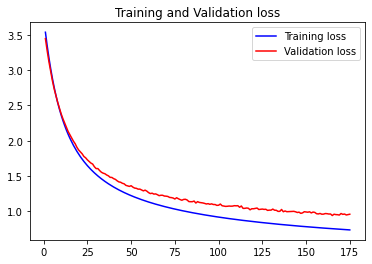

In [12]:
import matplotlib.pyplot as plt
acc = finetuned_model.history.history['accuracy']
val_acc = finetuned_model.history.history['val_accuracy']
loss = finetuned_model.history.history['loss']
val_loss = finetuned_model.history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()